# Data Loading

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

# Data Cleaning

In [2]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [6]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

# Text Preprocessing

In [7]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    


6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [8]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [9]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [10]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

# Time Based Sorting

In [11]:
final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
scores = final['Score']

# Split the Data Set into train and test

In [13]:
# ============================== loading libraries ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB
import warnings
# =============================================================================================

warnings.filterwarnings("ignore")
# split the data set into train and test
X_tr, X_test, y_tr, y_test = cross_validation.train_test_split(final['Text'].values, scores, test_size=0.3, random_state=0)

y_test = y_test.values
y_tr = y_tr.values

#sampling data
train_indices = np.random.choice(len(X_tr),40000,replace=False)
test_indices = np.random.choice(len(X_test),10000,replace=False)
X_tr = X_tr[train_indices]
y_tr = y_tr[train_indices]
X_test = X_test[test_indices]
y_test = y_test[test_indices]

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Converting Text to tfidfW2Vec

In [14]:
# Train your own Word2Vec model using X_tr
import gensim
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
i=0
list_of_sent_X_tr=[]
for sent in X_tr:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_X_tr.append(filtered_sentence)

In [15]:
import gensim
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
i=0
list_of_sent_X_test=[]
for sent in X_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_X_test.append(filtered_sentence)

In [16]:
w2v_model=gensim.models.Word2Vec(list_of_sent_X_tr,min_count=1,size=50, workers=4) 

In [17]:
tf_idf_X_tr_vect = TfidfVectorizer()
tf_idf_X_tr_vect.fit(X_tr)
final_tf_idf_X_tr_vect = tf_idf_X_tr_vect.transform(X_tr)
final_tf_idf_X_test_vect = tf_idf_X_tr_vect.transform(X_test)

In [18]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_X_tr_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_X_tr_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_tr: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try: 
            
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_X_tr_vect[row, tfidf_feat.index(word)]
            sent_vec +=(vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_X_tr_vectors.append(sent_vec)
    row += 1

In [19]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_X_tr_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_X_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_X_test_vect[row, tfidf_feat.index(word)]
            sent_vec +=(vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_X_test_vectors.append(sent_vec)
    row += 1

In [20]:
from sklearn.preprocessing import Imputer
X_tr_vector = Imputer().fit_transform(tfidf_sent_X_tr_vectors)
X_test_vector = Imputer().fit_transform(tfidf_sent_X_test_vectors)

# Column Standardization

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(X_tr_vector)
X_tr_vector = scaler.transform(X_tr_vector)
X_test_vector =scaler.transform(X_test_vector)

# Optimal Lamda using GridSearchCV

In [22]:
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'accuracy', cv=5)
model.fit(X_tr_vector, y_tr)

print(model.best_estimator_)
print(model.score(X_test_vector, y_test))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8708


# l2 regularizer

             precision    recall  f1-score   support

   negative       0.65      0.33      0.44      1523
   positive       0.89      0.97      0.93      8477

avg / total       0.85      0.87      0.85     10000

Coefficient of each feature: [[-0.02148334 -0.00771671  0.37975283 -0.01093354  0.10160761 -0.31947475
   0.14421895  0.58967275 -0.33323138  0.14916013  0.33392497  0.04635088
   0.2317835  -0.12900884 -0.11800748 -0.507742    0.38336439  0.48718191
   0.51972722 -0.10995839  0.26683105 -0.3704141   0.37613635  0.13068342
   0.21999848 -0.30984808  0.35583854 -0.27731904 -0.04567233 -0.14730684
  -0.35316189 -0.16127853 -0.12823419 -0.29798677 -0.68335272 -0.18764131
  -0.14746496  0.05019969  0.13800082 -0.4699487  -0.13729152 -0.38179335
  -0.02119468 -0.52283236  0.37517016  0.41994783 -0.38035818  0.3991036
  -0.06714348 -0.11354872]]
Training accuracy: 0.868675
Test accuracy: 0.8708


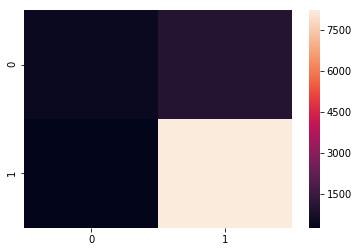

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=100,penalty='l2')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
pre_weights =classifier.coef_
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))

# l1 regulaizer

             precision    recall  f1-score   support

   negative       0.65      0.33      0.44      1523
   positive       0.89      0.97      0.93      8477

avg / total       0.85      0.87      0.85     10000

Coefficient of each feature: [[-0.02537209 -0.00342679  0.37268175 -0.00783492  0.10407612 -0.32086447
   0.14484637  0.58631419 -0.33146564  0.1489737   0.33162872  0.04592993
   0.2314186  -0.12963557 -0.1156677  -0.50386596  0.37910054  0.48157859
   0.50742386 -0.11036956  0.26005174 -0.37078057  0.37417319  0.13001073
   0.21880353 -0.30911548  0.35175632 -0.27372758 -0.04775251 -0.1516294
  -0.35221549 -0.16248199 -0.12870571 -0.29211531 -0.67943447 -0.18449404
  -0.14647675  0.04702939  0.13640395 -0.47051294 -0.13985228 -0.38324897
  -0.02215663 -0.52224346  0.3722824   0.41291763 -0.38440117  0.39989164
  -0.06725605 -0.10657371]]
Training accuracy: 0.868575
Test accuracy: 0.8708


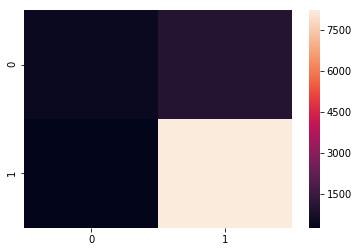

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=100,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))

# Optimal Lamda using RandomSearchCV

In [25]:
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 


tuned_parameters = {"C": stats.uniform(10**-4, 10**4)}
#Using GridSearchCV
model = RandomizedSearchCV(LogisticRegression(), tuned_parameters, scoring = 'accuracy', cv=5)
model.fit(X_tr_vector, y_tr)

print(model.best_estimator_)
print(model.score(X_test_vector, y_test))

LogisticRegression(C=2081.966358046061, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8708


# l2 Regularizer

             precision    recall  f1-score   support

   negative       0.65      0.33      0.44      1523
   positive       0.89      0.97      0.93      8477

avg / total       0.85      0.87      0.85     10000

Coefficient of each feature: [[-0.02145811 -0.00774323  0.37981036 -0.01095567  0.10159635 -0.31946629
   0.14421441  0.58970104 -0.33324475  0.14916016  0.3339474   0.04635605
   0.23178146 -0.12900686 -0.11802481 -0.50777367  0.38339275  0.48722474
   0.51981806 -0.10996087  0.26688201 -0.37041624  0.37615486  0.13068648
   0.22000994 -0.30985639  0.35586762 -0.27734813 -0.04566013 -0.14727749
  -0.35317288 -0.16127118 -0.12823363 -0.29803201 -0.68338875 -0.18766186
  -0.14747325  0.05022443  0.13801307 -0.46994852 -0.13727227 -0.38178365
  -0.02118869 -0.5228468   0.37519722  0.42000027 -0.38033656  0.39910696
  -0.06714948 -0.11359584]]
Training accuracy: 0.86865
Test accuracy: 0.8708


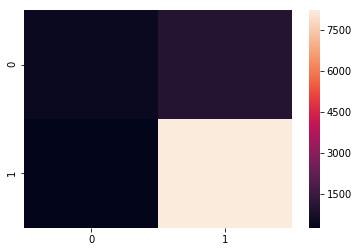

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=2081.966358046061,penalty='l2')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
pre_weights =classifier.coef_
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))

# l1 Regularizer

             precision    recall  f1-score   support

   negative       0.65      0.33      0.44      1523
   positive       0.89      0.97      0.93      8477

avg / total       0.85      0.87      0.85     10000

Coefficient of each feature: [[-0.02524006 -0.00362794  0.37357753 -0.00793196  0.10364396 -0.32075019
   0.14498482  0.58657668 -0.33173063  0.14897622  0.33158957  0.04597114
   0.23142058 -0.12976973 -0.11579756 -0.50416934  0.37933935  0.48218744
   0.50831144 -0.11051397  0.26048021 -0.37077771  0.37435197  0.13008113
   0.21875721 -0.30930598  0.35213644 -0.27407436 -0.04758721 -0.15142054
  -0.35246718 -0.16236234 -0.12877311 -0.29242746 -0.67970036 -0.18484139
  -0.14635431  0.04724313  0.13658911 -0.47062498 -0.13970511 -0.38303213
  -0.02219741 -0.52227815  0.37227361  0.41347029 -0.38400583  0.40001397
  -0.06728125 -0.10702999]]
Training accuracy: 0.8686
Test accuracy: 0.8708


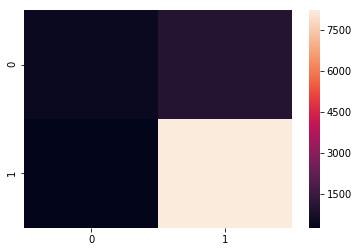

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=2081.966358046061,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))

             precision    recall  f1-score   support

   negative       0.25      0.02      0.03      1523
   positive       0.85      0.99      0.91      8477

avg / total       0.76      0.84      0.78     10000

Coefficient of each feature: [[0.         0.         0.         0.         0.         0.
  0.         0.30816471 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.15008203 0.         0.         0.
  0.         0.        ]]
Training accuracy: 0.8397
Test accuracy: 0.8431
No of Non-zero elements: 2


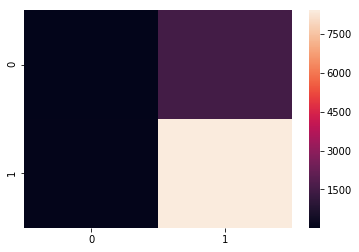

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
C_values = []
non_zero_values = []
test_accuracy =[]
classifier = LogisticRegression(C=0.0001,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(0.0001)

             precision    recall  f1-score   support

   negative       0.69      0.04      0.08      1523
   positive       0.85      1.00      0.92      8477

avg / total       0.83      0.85      0.79     10000

Coefficient of each feature: [[ 0.          0.          0.          0.          0.         -0.00464584
   0.          0.36997643 -0.12726638  0.01148451  0.          0.
   0.30447768  0.          0.          0.          0.07403868  0.18112123
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -0.15619997  0.
   0.          0.          0.01885211 -0.28652797 -0.06769562 -0.2784916
   0.         -0.01728363  0.          0.19925558  0.          0.
   0.          0.        ]]
Training accuracy: 0.846575
Test accuracy: 0.8514
No of Non-zero elements: 14


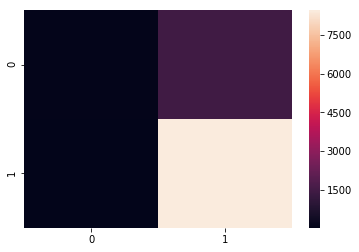

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=0.001,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(0.001)

             precision    recall  f1-score   support

   negative       0.66      0.27      0.38      1523
   positive       0.88      0.97      0.93      8477

avg / total       0.85      0.87      0.84     10000

Coefficient of each feature: [[ 0.          0.          0.          0.          0.00254656 -0.27821249
   0.13204329  0.43488169 -0.26427628  0.1435838   0.11213454  0.
   0.29684831  0.         -0.0265537  -0.32065139  0.26523766  0.28318445
   0.15705703  0.          0.01338325 -0.21930038  0.228251    0.15922481
   0.18175395 -0.18458284  0.15947251 -0.07457078  0.         -0.20141063
  -0.21441151 -0.08457121 -0.05355396 -0.06656362 -0.52178868 -0.18465904
  -0.07957202 -0.04365396  0.07653696 -0.45299952 -0.17513574 -0.44514246
   0.         -0.33462286  0.11166401  0.20740161 -0.35720141  0.15593112
   0.          0.        ]]
Training accuracy: 0.86555
Test accuracy: 0.8677
No of Non-zero elements: 39


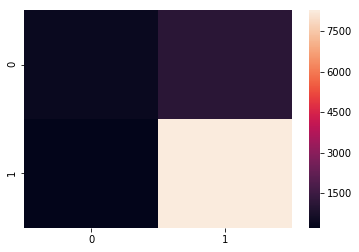

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=0.01,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(0.01)

             precision    recall  f1-score   support

   negative       0.65      0.32      0.43      1523
   positive       0.89      0.97      0.93      8477

avg / total       0.85      0.87      0.85     10000

Coefficient of each feature: [[-0.05595886  0.0365716   0.25900048  0.02315728  0.11815907 -0.3273774
   0.14542724  0.53208322 -0.3067564   0.1501096   0.28349898  0.02717554
   0.23578857 -0.1241123  -0.08218095 -0.44585966  0.3265926   0.40557526
   0.34401273 -0.10004009  0.16129899 -0.35933908  0.34012866  0.12804911
   0.20142482 -0.28823901  0.2979112  -0.21549226 -0.06251534 -0.19856953
  -0.32808578 -0.16418524 -0.12172712 -0.20824791 -0.62103978 -0.15214491
  -0.12230469  0.          0.11213128 -0.4721566  -0.16689651 -0.40398659
  -0.02070171 -0.49015118  0.31783506  0.31900391 -0.4218863   0.37401179
  -0.04698459 -0.02102598]]
Training accuracy: 0.868125
Test accuracy: 0.8706
No of Non-zero elements: 49


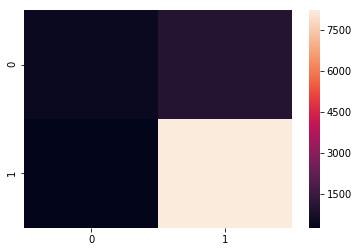

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=0.1,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(0.1)

             precision    recall  f1-score   support

   negative       0.65      0.33      0.43      1523
   positive       0.89      0.97      0.93      8477

avg / total       0.85      0.87      0.85     10000

Coefficient of each feature: [[-0.02864865  0.00111099  0.36058506 -0.00264445  0.10520806 -0.32158344
   0.14489699  0.58069979 -0.32857395  0.14880048  0.32607249  0.04398958
   0.23225483 -0.12901302 -0.11245524 -0.4975003   0.37339404  0.47336139
   0.48996297 -0.10940917  0.24885474 -0.36995971  0.37035364  0.12964484
   0.21693996 -0.30671646  0.34599833 -0.26790044 -0.04938748 -0.15660468
  -0.3499528  -0.16299619 -0.12817742 -0.28295945 -0.67293667 -0.18142689
  -0.14375555  0.04097754  0.13360121 -0.47070581 -0.14245072 -0.38541618
  -0.02195057 -0.51864434  0.36676731  0.40262084 -0.3883438   0.39765686
  -0.06521539 -0.09696227]]
Training accuracy: 0.868575
Test accuracy: 0.8707
No of Non-zero elements: 50


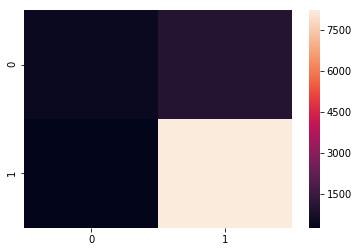

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=1,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(1)

             precision    recall  f1-score   support

   negative       0.65      0.33      0.44      1523
   positive       0.89      0.97      0.93      8477

avg / total       0.85      0.87      0.85     10000

Coefficient of each feature: [[-0.02537637 -0.00315504  0.37254627 -0.00756034  0.10383716 -0.32077642
   0.14490355  0.58615734 -0.3315404   0.14897613  0.33128878  0.0457665
   0.23150667 -0.12955796 -0.11560041 -0.50372033  0.37887799  0.48140259
   0.50696853 -0.11027956  0.25953239 -0.37067788  0.37397741  0.13007425
   0.21871894 -0.30921989  0.35160031 -0.27352219 -0.04773484 -0.15172066
  -0.35228111 -0.16244105 -0.12869665 -0.29178943 -0.67927494 -0.18454277
  -0.14617286  0.04671556  0.13617456 -0.47059722 -0.13985792 -0.38328344
  -0.02205723 -0.52204329  0.37195053  0.41261586 -0.38445998  0.39951927
  -0.06697252 -0.10636571]]
Training accuracy: 0.8686
Test accuracy: 0.8708
No of Non-zero elements: 50


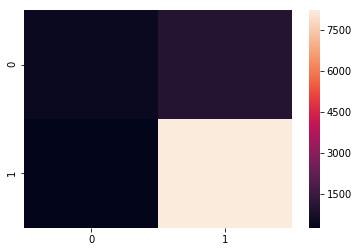

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=10,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(10)

             precision    recall  f1-score   support

   negative       0.65      0.33      0.44      1523
   positive       0.89      0.97      0.93      8477

avg / total       0.85      0.87      0.85     10000

Coefficient of each feature: [[-0.02498436 -0.00385248  0.37377917 -0.00817321  0.10376107 -0.32070776
   0.14482211  0.58676417 -0.33177494  0.14900461  0.33176391  0.04595187
   0.23144039 -0.12959339 -0.11591217 -0.50438393  0.37959892  0.48217928
   0.50885563 -0.11035347  0.26080947 -0.37071066  0.37454054  0.13016511
   0.21891416 -0.3093735   0.35223032 -0.27421    -0.04743699 -0.15112328
  -0.35250933 -0.16228203 -0.12872461 -0.29283278 -0.68006726 -0.18492929
  -0.1465111   0.04749555  0.13659796 -0.47055856 -0.13951573 -0.38307686
  -0.02205799 -0.52239156  0.37255797  0.4137743  -0.38392325  0.39990379
  -0.06728765 -0.10741414]]
Training accuracy: 0.868575
Test accuracy: 0.8708
No of Non-zero elements: 50


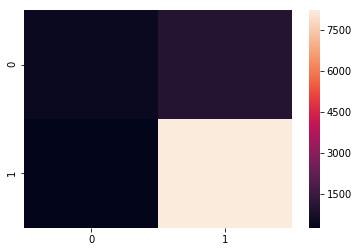

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=100,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(100)

# C vs Sparsity

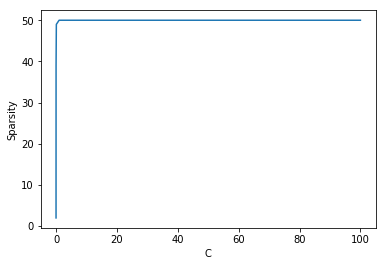

In [35]:
plt.plot(C_values, non_zero_values)
plt.xlabel('C')
plt.ylabel('Sparsity')
plt.show()

# C vs Test Accuracy

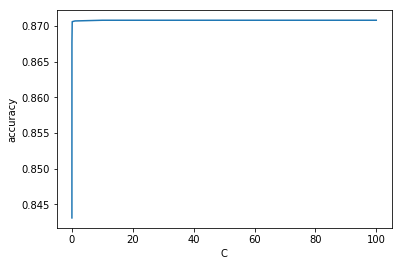

In [36]:
plt.plot(C_values, test_accuracy)
plt.xlabel('C')
plt.ylabel('accuracy')
plt.show()

# Checking Multicollinearity

In [37]:
#adding epsilon to train data for multicollinearity check
import scipy.stats
X_train = X_tr_vector.copy()
#X_train.todense()
print(scipy.stats.norm.rvs(loc=0, scale=0.01))
X_train.data += scipy.stats.norm.rvs(loc=0, scale=0.01)

-0.002253919747763873


             precision    recall  f1-score   support

   negative       0.77      0.03      0.05      1523
   positive       0.85      1.00      0.92      8477

avg / total       0.84      0.85      0.79     10000

Coefficient of each feature: [[ 0.02064683 -0.0387704  -0.06417264  0.00710476 -0.02715075 -0.06693142
   0.06206871  0.17610486 -0.11324898  0.08376812 -0.04490479  0.02427948
   0.1354142   0.02747547 -0.0390181  -0.07596328  0.10454959  0.14495824
   0.09215385  0.03415153 -0.00941729 -0.0581947   0.06600628  0.07150337
   0.04233938 -0.02033163  0.08300059  0.03597996 -0.04158818 -0.05050207
  -0.02076352 -0.02138101 -0.04507698 -0.07950915 -0.12506235 -0.03168238
  -0.02096899 -0.0058341   0.08349652 -0.13904643 -0.06903191 -0.14929111
   0.00312343 -0.07527206  0.05393199  0.0854635  -0.05297635  0.0009906
   0.02840827  0.00742097]]
Training accuracy: 0.845975
Test accuracy: 0.8507


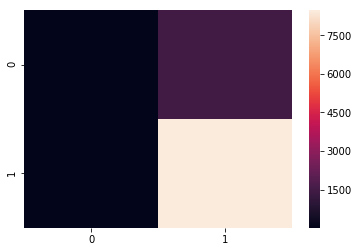

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=0.0001,penalty='l2')
classifier.fit(X_train, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
post_weights = classifier.coef_
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_train, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))

In [41]:
difference =[]
for i in post_weights:
    difference.append(np.abs(pre_weights-post_weights))

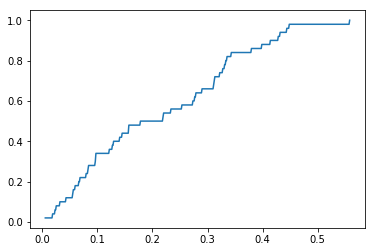

In [42]:
counts, bin_edges = np.histogram(difference, bins=500, density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)

# Conclusion

In [43]:
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ['CV Method', 'Optimal C','regularizer','Train Error','Test Error']
t.add_row(["GridSearchCV","100","l2","0.131325","0.1292"])
t.add_row(["GridSearchCV","100","l1","0.131425","0.1292"])
t.add_row(["RandomSearchCV","2081.966358046061","l2","0.13135","0.1292"])
t.add_row(["RandomSearchCV","2081.966358046061","l1","0.1314","0.1292"])
print(t)
print("**C Vs Sparsity with l1 regularizer**")
t1 = PrettyTable()
t1.field_names = ['C', 'Sparsity']
t1.add_row(["0.0001","2"])
t1.add_row(["0.001","14"])
t1.add_row(["0.01","39"])
t1.add_row(["0.1","49"])
t1.add_row(["1","50"])
t1.add_row(["10","50"])
t1.add_row(["100","50"])
print(t1)
print("->Features are multicollinear hence |wj| can not be used for Feature Importance")


+----------------+-------------------+-------------+-------------+------------+
|   CV Method    |     Optimal C     | regularizer | Train Error | Test Error |
+----------------+-------------------+-------------+-------------+------------+
|  GridSearchCV  |        100        |      l2     |   0.131325  |   0.1292   |
|  GridSearchCV  |        100        |      l1     |   0.131425  |   0.1292   |
| RandomSearchCV | 2081.966358046061 |      l2     |   0.13135   |   0.1292   |
| RandomSearchCV | 2081.966358046061 |      l1     |    0.1314   |   0.1292   |
+----------------+-------------------+-------------+-------------+------------+
**C Vs Sparsity with l1 regularizer**
+--------+----------+
|   C    | Sparsity |
+--------+----------+
| 0.0001 |    2     |
| 0.001  |    14    |
|  0.01  |    39    |
|  0.1   |    49    |
|   1    |    50    |
|   10   |    50    |
|  100   |    50    |
+--------+----------+
->Features are multicollinear hence |wj| can not be used for Feature Importance
